### Complete walk-trough of process

In [386]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

In [387]:
# Force reload when subsequent execution
import helper_functions
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from 'C:\\Source\\predicting-house-prices\\helper_functions.py'>

In [6]:
# Loading train and test data
train_df = pd.read_csv('data/train.csv')
print('Loaded %s training rows with %s columns' % (train_df.shape[0], train_df.shape[1]))
test_df = pd.read_csv('data/test.csv')
print('Loaded %s test rows with %s columns' % (test_df.shape[0], test_df.shape[1]))
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

Loaded 1460 training rows with 81 columns
Loaded 1459 test rows with 80 columns


In [14]:
from sklearn.model_selection import train_test_split

# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

# Creating first naive pipeleine for evaluation
pipeline = Pipeline([
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [17]:
# Fitting the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x00000197F73AC8C8>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [18]:
# Making prediction on the test set
predictions = pipeline.predict(X_test)

In [19]:
# Cleaning the predictions from 0 and below (temporary step which will be unnecessary later)
predictions[predictions <= 0] = 0

In [20]:
# Print first benchmark of model
print_benchmark(y_test, predictions, log_transform=True)

R2-score: 0.761081041605
RMSE (log): 0.549234845034476


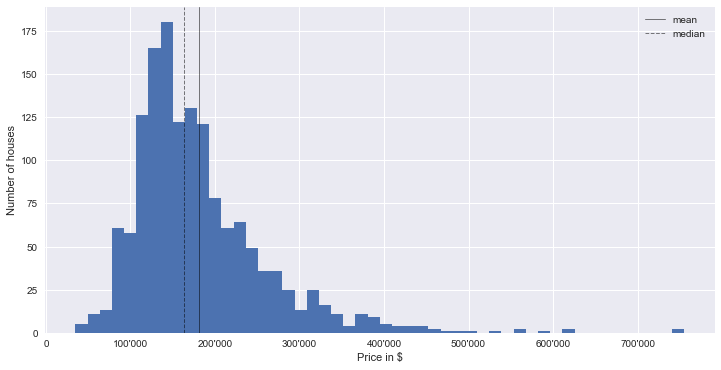

In [78]:
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))

# We analyze the distribution of target variable SalePrice
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(train_df['SalePrice'].mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(train_df['SalePrice'].median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(train_df.loc[:, 'SalePrice'], bins=50)
plt.show()

In [37]:
from scipy.stats import skew
skew(train_df.loc[:, 'SalePrice'])

1.880940746034036

In [26]:
# The sale price is heavily right-skewed so we will need to apply a log transform to even the distribution. 
y = np.log1p(y)

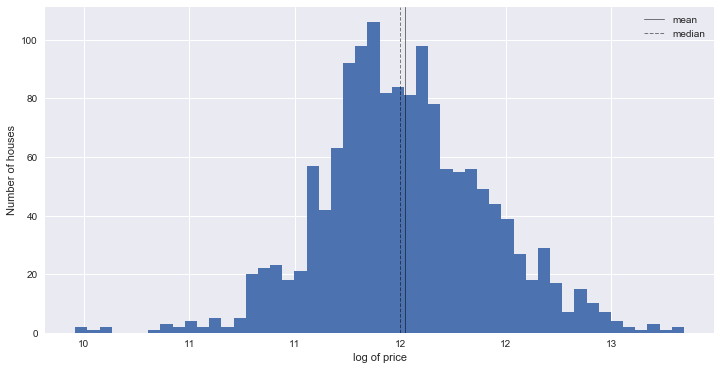

In [79]:
# Evaluate our transformation
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_ylabel('Number of houses')
ax.set_xlabel('log of price')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(y.mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(y.median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(y, bins=50)
plt.show()

In [39]:
# Target variable now has decent skew
skew(y)

0.12122191311528363

In [40]:
# We train the same pipeline as above with the skewed variable
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x00000197F73AC8C8>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [42]:
# And make predictions
predictions = pipeline.predict(X_test)
predictions[predictions <= 0] = 0
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


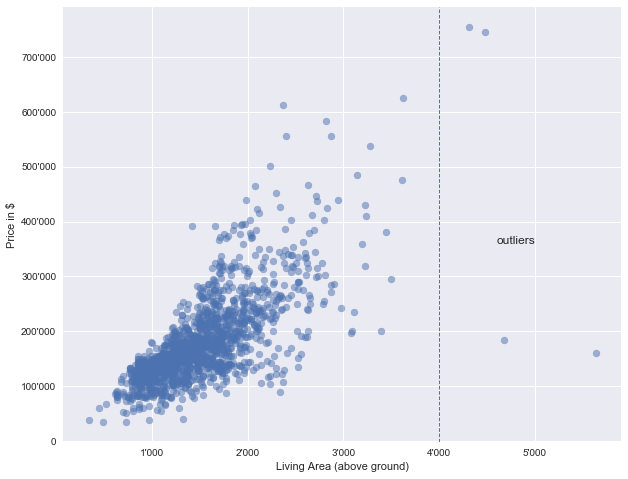

In [53]:
# We explore the data for possible outliers
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.5)
ax.set_xlabel('Living Area (above ground)')
ax.set_ylabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(4000, linestyle='--', linewidth=1)
ax.text(4600, 360000, 'outliers')
plt.show()

In [55]:
outliers = X[X['GrLivArea'] >= 4000]
print('%s outliers to remove (%s)' % (len(outliers), outliers.index))

4 outliers to remove (Int64Index([523, 691, 1182, 1298], dtype='int64'))


In [56]:
# We now remove the outliers from the data
X = X.drop(outliers.index)
y = y.drop(outliers.index)

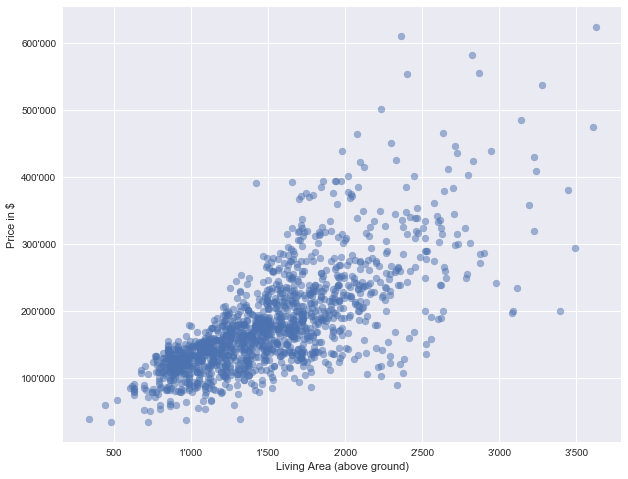

In [67]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(X['GrLivArea'], np.expm1(y), alpha=.5)
ax.set_xlabel('Living Area (above ground)')
ax.set_ylabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

In [76]:
# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

In [77]:
predictions = pipeline.predict(X_numerical)
predictions[predictions <= 0] = 0
print_benchmark(y, predictions, log_transform=False)

R2-score: 0.800862055373
RMSE (log): 0.1766882689892123


In [110]:
# To deepen our standing of the data we explore the directions of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [111]:
# Finde explained variance of the components
pca.explained_variance_ratio_

array([ 0.98371816,  0.0044297 ])

In [112]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

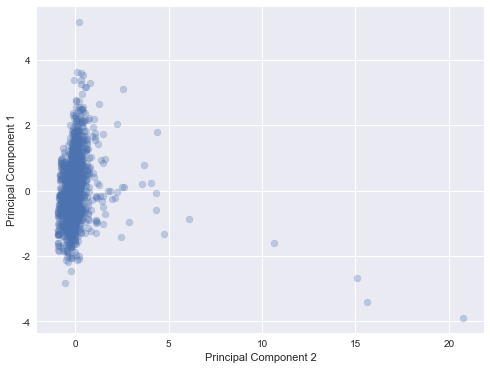

In [123]:
# We visualize the principal components
fig, ax1 = plt.subplots(1, figsize=(8, 6))
ax1.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax1.set_ylabel('Principal Component 1')
ax1.set_xlabel('Principal Component 2')
ax1.yaxis.set_major_formatter(thousand_formatter)
ax1.xaxis.set_major_formatter(thousand_formatter)
plt.show()

In [126]:
# Now we apply scaling to the process
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_numerical)
X_numerical = scaler.transform(X_numerical)

In [127]:
from sklearn.decomposition import PCA

# And we repeat the process for the scaled data
pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [128]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

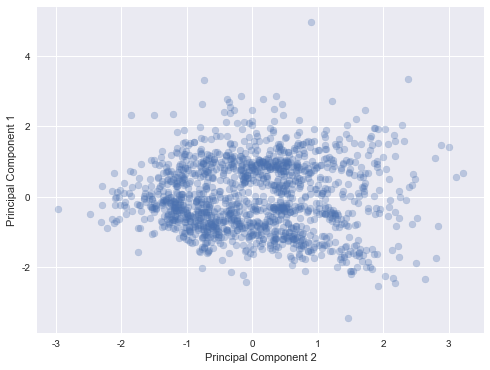

In [129]:
# We visualize the principal components
fig, ax1 = plt.subplots(1, figsize=(8, 6))
ax1.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax1.set_ylabel('Principal Component 1')
ax1.set_xlabel('Principal Component 2')
ax1.yaxis.set_major_formatter(thousand_formatter)
ax1.xaxis.set_major_formatter(thousand_formatter)
plt.show()

In [133]:
# We determine the cumluative sum without restriction
pca = PCA(whiten=True)
pca.fit(X_numerical)
cumsum = np.cumsum(pca.explained_variance_ratio_)

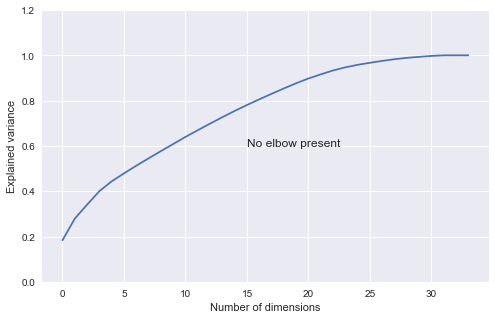

In [134]:
# And  plot the data
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cumsum)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Explained variance')
ax.set_ylim(0,1.2)
ax.text(15, .6, 'No elbow present')
plt.show()

In [170]:
# We try how our naive model performs when doing pca
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

pca = PCA(whiten=True, n_components=5)
X_reduced = pca.fit_transform(X_numerical)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x00000197F73AC8C8>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [171]:
predictions = pipeline.predict(X_test)

In [172]:
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.648762860889
RMSE (log): 0.23425324215665486


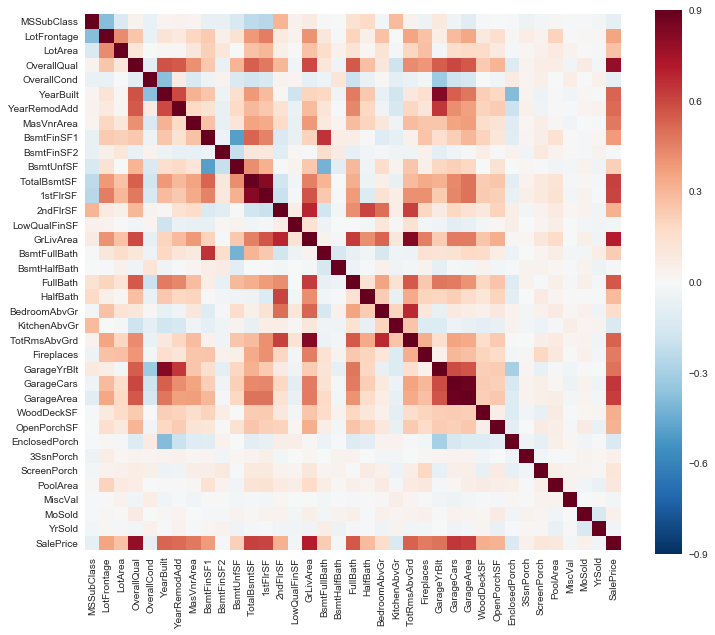

In [175]:
import seaborn as sns

# Next we explore the correlations between the features visually
corrmat = pd.read_csv('data/train.csv').drop(['Id'], axis=1).corr()
plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [202]:
# We find highest correlating features programmatically
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [203]:
X = X.select_dtypes(exclude=['object'])

In [204]:
# Removes redundant feature pairs
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Returns the top n correlations
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 10))

Top Absolute Correlations
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
YearRemodAdd  GarageYrBlt     0.642277
GrLivArea     FullBath        0.630012
2ndFlrSF      TotRmsAbvGrd    0.616423
dtype: float64


In [205]:
# Remove outliers and perform log transform
X, y = prepare_inputs(X, y)

In [221]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

# Now we evaluate how these features to affect our prediction performance
pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('remove_high_correlations', DFTransform(lambda X: X.drop(['GarageCars','TotRmsAbvGrd','2ndFlrSF','TotalBsmtSF'], axis=1))),
    ('lin_reg', linear_model.LinearRegression())
])

In [230]:
# We test performance with these higly correlating features removed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.881869697547
RMSE (log): 0.13585200512095447


In [228]:
# And without the removal of these features
pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('lin_reg', linear_model.LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.881869697547
RMSE (log): 0.13585200512095447


In [231]:
# Now handle missing data. First we reload data to eliminate side effects
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [232]:
X, y = prepare_inputs(X, y)

In [233]:
# Which columns do have null values
X.columns[X.isnull().any(axis=0)]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [69]:
# How many null rows in each column
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

LotFrontage      259
Alley           1365
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

In [234]:
# First we handle the numerical features with missing values
X_numerical = X.select_dtypes(exclude=['object'])
null_columns = X_numerical.columns[X_numerical.isnull().any()]
X_numerical[null_columns].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

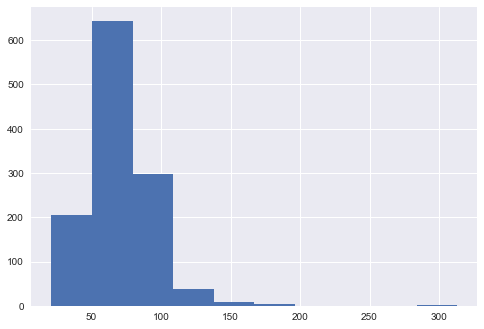

In [71]:
# We start with LotFrontage
X_numerical['LotFrontage'].hist()

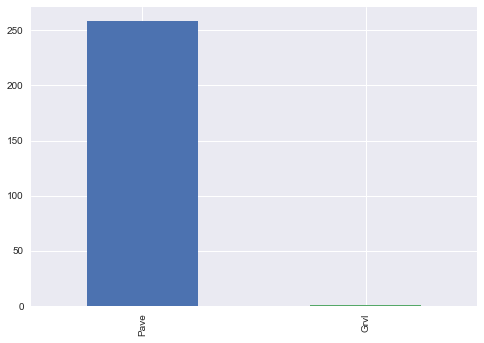

In [235]:
# From the documentation we do not know, why there are NaNs with this features. 
# Because there are small other values we could assume that NaNs means there are no streets connected to this properties.
X[X['LotFrontage'].isnull()]['Street'].value_counts().plot(kind='bar')

In [236]:
# But the road access does suggest, that there are actually streets.
X[X['LotFrontage'].isnull()].corr().abs().iloc[0, :].sort_values(ascending=False).head()

MSSubClass     1.000000
GarageYrBlt    0.300610
YearBuilt      0.277406
2ndFlrSF       0.275932
1stFlrSF       0.244767
Name: MSSubClass, dtype: float64

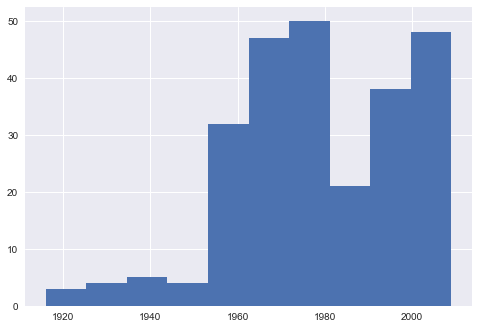

In [238]:
# They also have garages so we will fill in medians in this column
X[X['LotFrontage'].isnull()]['GarageYrBlt'].hist()

In [241]:
# We continue with MasVnrArea
# The NaNs in area are corresponding to the NaNs in type. 
# There are not so many of those and we assume they can be replaced with 0
X[X['MasVnrArea'].isnull()]['MasVnrType'] 

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [244]:
# Next we examine the year the garage was buillt
X[X['GarageYrBlt'].isnull()]['GarageType'].head()

39    NaN
48    NaN
78    NaN
88    NaN
89    NaN
Name: GarageType, dtype: object

In [257]:
# Corresponds with NaNs in type so we can safely assume there is no garage. 
# We replace the values with 0 - so they are even older than the oldest ones.
X_numerical = X.select_dtypes(exclude=['object'])
X_numerical = fill_nans(X_numerical, ['LotFrontage'], ['MasVnrArea', 'GarageYrBlt'])

In [260]:
# The BsmtXXX are coresponding to no basement and can be replaced with 0 
# while the GarageCars are corresponding to no Garage and can also be replaced with 0
'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'

('BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea')

In [261]:
# Now we cleanup the categoricals
X_categorical = X.select_dtypes(include=['object'])
null_columns = X_categorical.columns[X_categorical.isnull().any()]
X_categorical[null_columns].isnull().sum()

Alley           1365
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

In my opinion we need to use both options here, otherwise we loose one dimension if there are no nans

In [262]:
# These can be cleaned with the pandas function
# In my opinion we need to use both options here, otherwise we loose one dimension if there are no nans
pd.get_dummies(X_categorical, dummy_na=True, drop_first=True).head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_nan,LotShape_IR2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [346]:
# Now we have built a helper function and we separate
# transformation and prediction pipelines
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda x: fill_numerical_nans(x))),
    ('encode_dummies', DFTransform(lambda x: create_dummies(x)))
])

In [424]:
pipeline = Pipeline([
    ('lin_reg', LinearRegression())
])

In [348]:
# Now we evaluate our model with the encoded variables
(trans_p, fit_p, _) = train_pipeline(trans_pipeline, pipeline, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 287)
Create train/test split
Create predictions...(train)
R2-score: 0.956370687386
RMSE (log): 0.08254248626350628
Create predictions...(test)
R2-score: 0.882556838871
RMSE (log): 0.13545631633507443
Fitting the pipeline to all the data...
Score: 0.94784228


In [426]:
# This did not help our model a lot. We need to handle ordinal values first.
# We encode the ordinal features with a label encoder after we did some cleaning
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
])

In [427]:
# Now we evaluate our model with the encoded variables
(trans_p, fit_p, X_test_transformed) = train_pipeline(trans_pipeline, pipeline, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.950934519959
RMSE (log): 0.08753392184103406
Create predictions...(test)
R2-score: 0.884098845793
RMSE (log): 0.13456411991043715
Fitting the pipeline to all the data...
Score: 0.94160933


In [373]:
# We check the same model with cross validation
from sklearn.metrics import make_scorer

In [374]:
train_df = pd.read_csv('data/train.csv')
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)

In [375]:
X = trans_pipeline.fit_transform(X)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


In [376]:
from sklearn.cross_validation import cross_val_score
scorer = make_scorer(rmse_score)
score = cross_val_score(pipeline, X, y, cv=5, scoring=scorer)

In [377]:
score.mean()

0.12674098770168502

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179465.05
Difference in means is: -1456.1434666


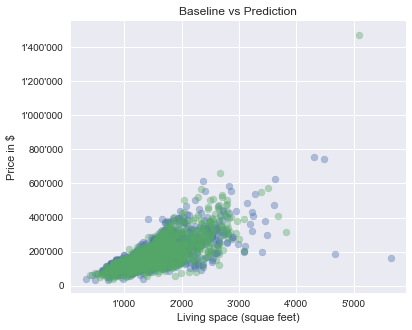

In [388]:
predictions = execute_pipeline(trans_p, fit_p, X_test_trans)

In [389]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180822102030.csv


Kaggle Score: 0.13187

In [397]:
# We plot the learning curve of our naive model to examine potential variance and bias
def plot_learning_curve(transformation_pipeline, estimation_pipeline):
    train_df =  pd.read_csv('data/train.csv')
    X_train = train_df.drop(['SalePrice','Id'], axis=1)
    y_train = train_df['SalePrice']
    X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
    X_train, y_train = prepare_inputs(X_train, y_train)
    X_train_trans = transformation_pipeline.fit_transform(X_train)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_trans, y_train, test_size=.33, random_state=42)
    
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        estimation_pipeline.fit(X_train[:m], y_train[:m])
        y_train_predict = estimation_pipeline.predict(X_train[:m])
        y_valid_predict = estimation_pipeline.predict(X_valid)
        
        train_errors.append(math.sqrt(mean_squared_error(y_train_predict, y_train[:m])))
        val_errors.append(math.sqrt(mean_squared_error(y_valid_predict, y_valid)))
    
    fig, ax = plt.subplots(1, figsize=(8, 7))
    ax.plot(train_errors)
    ax.plot(val_errors)
    ax.set_xlabel('training size')
    ax.set_ylabel('RMSE (log)')
    ax.set_ylim([0, .6])
    plt.title('Training curve')
    plt.legend(['training', 'validation'])
    plt.show()

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


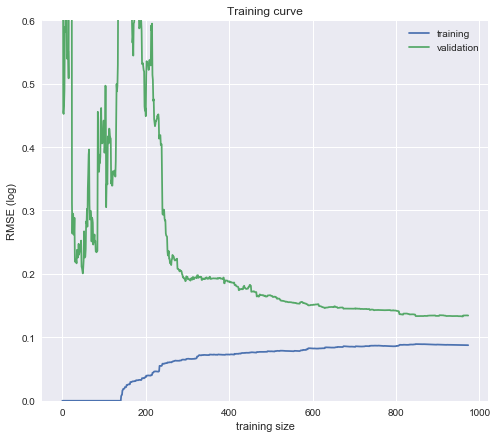

In [398]:
plot_learning_curve(trans_pipeline, 
    Pipeline([
    ('lin_reg', LinearRegression())
]))

In [404]:
import warnings
warnings.filterwarnings(action='ignore')

In [428]:
from sklearn.model_selection import GridSearchCV    
from sklearn.linear_model import Ridge

# We explore l2-regularization with a closed form approach
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
            'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
            'ridge_regression__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],    
            'ridge_regression__normalize': [True, False],
            'ridge_regression__fit_intercept': [True, False],
}
     
# For parameter optimization we do a grid search first
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ridge_regression', Ridge(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'ridge_regression__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'ridge_regression__normalize': [True, False], 'ridge_regression__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [429]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001))])

In [430]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.941821122695
RMSE (log): 0.09531714573065658
Create predictions...(test)
R2-score: 0.900418228006
RMSE (log): 0.12473126297994011
Fitting the pipeline to all the data...
Score: 0.93453861


Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179207.90
Difference in means is: -1713.29138721


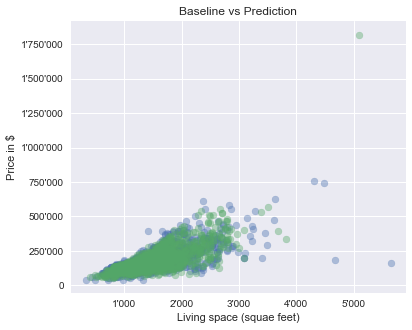

In [431]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [412]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180822105641.csv


Kaggle score: 0.12114

In [432]:
from sklearn.model_selection import GridSearchCV    
from sklearn.linear_model import SGDRegressor

# We no try a non closed moethod with stochastic gradient
# descent regressor with a l2 method. This will probably not
# work well due to limited numer of observations.
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
        'sgd_regression__penalty': ['l1', 'l2', 'elasticnet'],
        'sgd_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'sgd_regression__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
}
     
estimator = GridSearchCV(Pipeline([
                    ('sgd_regression', SGDRegressor(penalty='l2', random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train.ravel())

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sgd_regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sgd_regression__penalty': ['l1', 'l2', 'elasticnet'], 'sgd_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'sgd_regression__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [433]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: -929.232413768
RMSE (log): 12.052693010797169
Create predictions...(test)
R2-score: -920.911642034
RMSE (log): 12.001348427762704
Fitting the pipeline to all the data...
Score: -59935341.26321057


In [434]:
from sklearn.model_selection import GridSearchCV   
from sklearn.linear_model import Lasso

# Now using l1 regularization instead of l2 with lasso regression
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False],
              'lasso_regression__fit_intercept' : [True, False]               
             }

estimator = GridSearchCV(Pipeline([
        ('lasso_regression', Lasso(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False], 'lasso_regression__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [435]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [436]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.938915180971
RMSE (log): 0.0976686099113744
Create predictions...(test)
R2-score: 0.902818248711
RMSE (log): 0.12321902142673866
Fitting the pipeline to all the data...
Score: 0.92834489


In [440]:
from sklearn.preprocessing import RobustScaler

# Because lasso is sensitive to outliers, we also try the algorithm with a scaling before. 
# For this we use add the RobustScaler to our pipeline and remove the normalization
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__fit_intercept' : [True, False],  
              'robust_scaler__with_scaling' : [True, False],
              'robust_scaler__with_centering' : [True, False]
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('robust_scaler', RobustScaler()),
        ('lasso_regression', Lasso(random_state=42, normalize=False))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso_regression', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__fit_intercept': [True, False], 'robust_scaler__with_scaling': [True, False], 'robust_scaler__with_centering': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [441]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso_regression', Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [442]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.935532238606
RMSE (log): 0.1003366635924241
Create predictions...(test)
R2-score: 0.901094332602
RMSE (log): 0.12430711402605214
Fitting the pipeline to all the data...
Score: 0.92585781


In [443]:
from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import RobustScaler

# The parameter normalize beats the performance of the RobustScaler
# So we go back to our  model before and make a submission
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    Pipeline(memory=None, steps=[('lasso_regression', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]), show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.938915180971
RMSE (log): 0.0976686099113744
Create predictions...(test)
R2-score: 0.902818248711
RMSE (log): 0.12321902142673866
Fitting the pipeline to all the data...
Score: 0.92834489


Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178491.16
Difference in means is: -2430.0352133


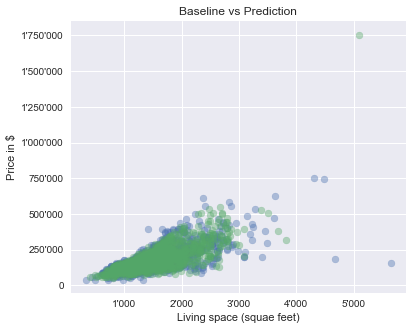

In [444]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [601]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728095727.csv


Kaggle score: 0.12391

In [446]:
from sklearn.model_selection import GridSearchCV  
from sklearn.linear_model import ElasticNet

# We use the middle ground between lasso (l1) and ridge (l2)
# and compare an ElasticNet regressor
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)
X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'elasticnet__alpha': [0.001, 0.01, 0.1, 1],
             'elasticnet__l1_ratio': [0.25, 0.5, 0.75],
             'elasticnet__normalize': [True, False]}

# Again we perform a grid search on important parameters
estimator = GridSearchCV(Pipeline([
                    ('elasticnet', ElasticNet())
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__alpha': [0.001, 0.01, 0.1, 1], 'elasticnet__l1_ratio': [0.25, 0.5, 0.75], 'elasticnet__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [447]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('elasticnet', ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [448]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.9391228552
RMSE (log): 0.09750244323873763
Create predictions...(test)
R2-score: 0.900576917651
RMSE (log): 0.12463183990631606
Fitting the pipeline to all the data...
Score: 0.92968717


In [468]:
from sklearn.ensemble import BaggingRegressor

# Now we build some ensembles. We start with bagging
# Best learner so far is ridge regression. 
bagging_estimator = BaggingRegressor(
        Pipeline(memory=None, steps=[('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, 
                                                                max_iter=None, normalize=False, random_state=42, 
                                                                solver='cholesky', tol=0.001))]), 
        n_estimators=500, bootstrap=True, n_jobs=4
)

In [469]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    bagging_estimator, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.940889683244
RMSE (log): 0.09607712617006492
Create predictions...(test)
R2-score: 0.901585004716
RMSE (log): 0.12399838616258653
Fitting the pipeline to all the data...
Score: 0.93394083


Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179150.72
Difference in means is: -1770.47972781


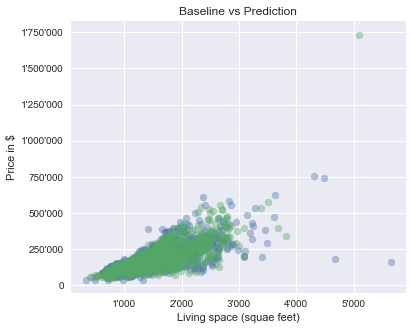

In [471]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed, show_plot=True)

In [472]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180822130325.csv


Kaggle: 0.12094

In [484]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

# Bagging estimators where slightly better with generalization so we
# try a sequential approach with boosting
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'ada_boost__loss': ['linear', 'square', 'exponential'],
    'ada_boost__learning_rate': [1, 0.01, 0.0001]
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ada_boost', AdaBoostRegressor(
                                    base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
                                       normalize=False, random_state=42, solver='cholesky', tol=0.001),
                                    n_estimators=500))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=500,
         random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ada_boost__loss': ['linear', 'square', 'exponential'], 'ada_boost__learning_rate': [1, 0.01, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [485]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=0.0001, loss='square', n_estimators=500,
         random_state=None))])

In [486]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
                                                 estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.942779910127
RMSE (log): 0.09452846999059274
Create predictions...(test)
R2-score: 0.901297004302
RMSE (log): 0.12417968728521382
Fitting the pipeline to all the data...
Score: 0.93502640


Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179204.13
Difference in means is: -1717.06925137


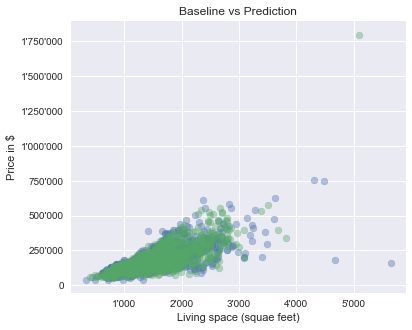

In [487]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [488]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180822133045.csv


Kaggle score: 0.12088

In [491]:
import xgboost as xgb

# We evaluate a non-sklearn algorithm for comparision
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)
X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
                'xgboost__booster': ['gbtree', 'gblinear','dart'],
                'xgboost__learning_rate': [.1, .3, .9],
                'xgboost__gamma': [0, 1, 10, 20],
                'xgboost__max_depth': [1, 3, 6],
                'xgboost__subsample': [.2, .4, .6],
                'xgboost__n_estimators': [5, 50, 500],
             }

estimator = GridSearchCV(Pipeline([
                    ('xgboost', xgb.XGBRegressor(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgboost', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgboost__booster': ['gbtree', 'gblinear', 'dart'], 'xgboost__learning_rate': [0.1, 0.3, 0.9], 'xgboost__gamma': [0, 1, 10, 20], 'xgboost__max_depth': [1, 3, 6], 'xgboost__subsample': [0.2, 0.4, 0.6], 'xgboost__n_estimators': [5, 50, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [493]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('xgboost', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6))])

In [492]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.9940049981
RMSE (log): 0.030597294268063985
Create predictions...(test)
R2-score: 0.894287748036
RMSE (log): 0.12851329452522361
Fitting the pipeline to all the data...
Score: 0.98906090


Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 177773.81
Difference in means is: -3147.38339041


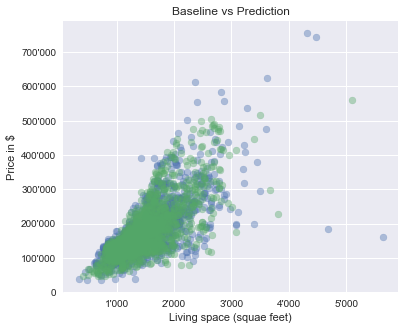

In [494]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [495]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180822143637.csv


Kaggle score:  0.12920